In [109]:
import os
os.chdir("/home/zsteve/wtf/manuscript/faces/run_wtf")

In [110]:
PLT_CELL = 2.5
figs_path = "/home/zsteve/wtf/manuscript/figs/"

In [111]:
import glob
dirnames = glob.glob("r_*")
r = [int(d.split('_')[1]) for d in dirnames]

In [112]:
import sklearn
import tensorly as tl
from sklearn import decomposition, neighbors
def get_pca_testerr(X_train, X_test, r, target, train_idx, test_idx):
    corr = lambda x, y: 1 - np.dot(x/np.linalg.norm(x), y/np.linalg.norm(y))
    pca = sklearn.decomposition.PCA(n_components = r, svd_solver = 'full')
    X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
    X_test_pca = pca.transform(tl.unfold(X_test, 0))
    clf_pca = neighbors.KNeighborsClassifier(n_neighbors = 1, metric = corr)
    clf_pca.fit(X_train_pca, target[train_idx])
    # err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
    err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
    return err_test

In [113]:
import matplotlib.pyplot as plt
from sklearn import cluster

import sys
sys.path.insert(0, "/home/zsteve/wtf/src")
import wtf

In [114]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

In [115]:
import numpy as np
err_ot_all = []
err_cp_all = []
err_pca_all = []
nmi_ot_all = []
nmi_cp_all = []
for d in dirnames:
    outfiles = glob.glob(d + "/*.npz")
    err_ot = []
    err_cp = []
    err_pca = []
    nmi_ot = []
    nmi_cp = []
    for f in outfiles:
        out = np.load(f, allow_pickle = True)
        s = out['classif']
        err_ot += [1-out['classif'].item()['ot']['err_test'], ]
        err_cp += [1-out['classif'].item()['cp']['err_test'], ]
        err_pca += [1-out['classif'].item()['pca']['err_test'], ] 
        # recompute PCA.
        # err_pca += [1-get_pca_testerr(out['X_train'], out['X_test'], out['A'][0].shape[-1], out['target'], out['train_idx'], out['test_idx'])]
        nmi_ot += [out['nmi'].item()['ot'], ]
        nmi_cp += [out['nmi'].item()['cp'], ]
        
    err_ot_all += [err_ot, ]
    err_cp_all += [err_cp, ]
    err_pca_all += [err_pca, ]
    nmi_ot_all += [nmi_ot, ]
    nmi_cp_all += [nmi_cp, ]

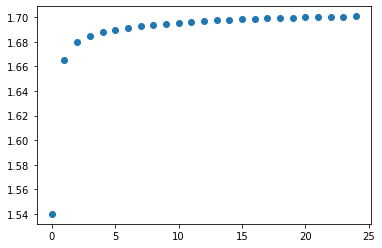

In [116]:
plt.scatter(np.arange(25), out['dual_objs'][0])

In [117]:
err_ot_all = [err_ot_all[i] for i in np.argsort(r)]
err_cp_all = [err_cp_all[i] for i in np.argsort(r)]
err_pca_all = [err_pca_all[i] for i in np.argsort(r)]
nmi_ot_all = [nmi_ot_all[i] for i in np.argsort(r)]
nmi_cp_all = [nmi_cp_all[i] for i in np.argsort(r)]
r = np.sort(r)

In [118]:
# import copy
# err_wnmf_all = copy.copy(err_ot_all)
# err_nmf_all = copy.copy(err_cp_all)

In [119]:
def set_violin_color(v, c, alpha = None):
    for k in v.keys():
        if k == "bodies":
            for pc in v[k]:
                pc.set_facecolor(c)
                pc.set_edgecolor(c)
                if alpha is not None:
                    pc.set_alpha(alpha)
        else:
            pc = v[k]
            pc.set_edgecolor(c)
            if alpha is not None:
                pc.set_alpha(alpha)
    return

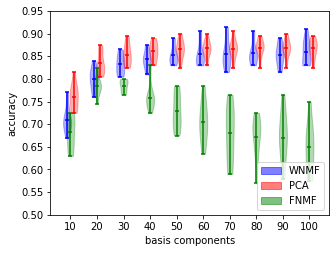

In [120]:
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
viol = plt.violinplot(err_ot_all, showmeans = True, positions = np.arange(len(r)) - 0.125, widths = 0.3);
set_violin_color(viol, 'blue')
viol = plt.violinplot(err_cp_all, showmeans = True, positions = np.arange(len(r)), widths = 0.3);
set_violin_color(viol, 'green')
viol = plt.violinplot(err_pca_all, showmeans = True, positions = np.arange(len(r)) + 0.125, widths = 0.3);
set_violin_color(viol, 'red')
plt.xticks(np.arange(len(r)), r);
leg = plt.legend(['WNMF', 'PCA', 'FNMF'], loc = 'lower right')
leg.legendHandles[0].set_color("blue")
leg.legendHandles[0].set_alpha(0.5)
leg.legendHandles[1].set_color("red")
leg.legendHandles[1].set_alpha(0.5)
leg.legendHandles[2].set_color("green")
leg.legendHandles[2].set_alpha(0.5)
plt.ylabel("accuracy")
plt.xlabel("basis components")
plt.ylim(0.5, 0.95)
plt.savefig(figs_path + "faces_wnmf_rank_accuracy.pdf")

Text(0.5, 0, 'basis components')

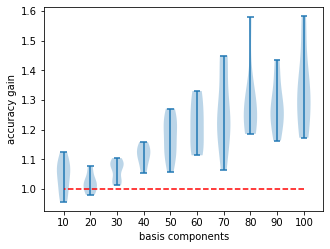

In [121]:
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
ratio_ot_cp = [np.array(err_ot_all[i])/np.array(err_cp_all[i])  for i in range(len(err_ot_all))]
plt.violinplot(ratio_ot_cp);
plt.hlines(1, len(ratio_ot_cp), 1, color = 'red', linestyle = 'dashed')
plt.xticks(np.arange(len(r))+1, r);
plt.ylabel("accuracy gain")
plt.xlabel("basis components")

Text(0.5, 0, 'basis components')

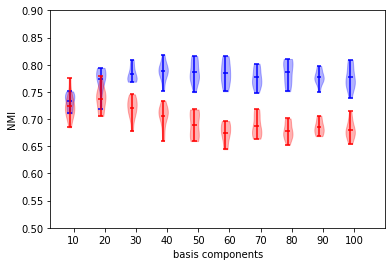

In [122]:
viol = plt.violinplot(nmi_ot_all, showmeans = True, positions = np.arange(len(r)) - 0.125, widths = 0.3);
set_violin_color(viol, 'blue')
viol = plt.violinplot(nmi_cp_all, showmeans = True, positions = np.arange(len(r)) - 0.125, widths = 0.3);
set_violin_color(viol, 'red')
plt.xticks(np.arange(len(r))+1, r);
plt.ylim(0.5, 0.9)
plt.xticks(np.arange(len(r)), r);
plt.ylabel("NMI")
plt.xlabel("basis components")

In [123]:
err_ot = np.array(err_ot_all).mean(1)
size_ot = (32 + 32)*r + 200*r

In [124]:
# err_ot_nmf = np.array(err_ot_all).mean(1)
# size_ot_nmf = (32*32)*r + 200*r

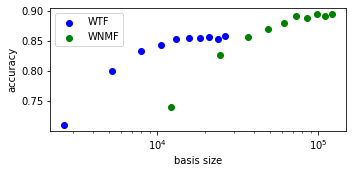

In [125]:
plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
plt.scatter(size_ot, err_ot, color = 'blue', label = "WTF")
plt.scatter(size_ot_nmf, err_ot_nmf, color = 'green', label = "WNMF")
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("basis size")
plt.legend()
plt.tight_layout()
plt.savefig(figs_path + "faces_basissize_accuracy.pdf")

In [68]:
out = np.load("/home/zsteve/wtf/manuscript/faces/run_wnmf/r_10/output_1.npz", allow_pickle = True)

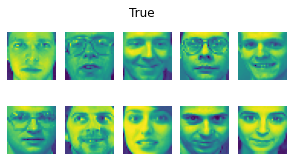

In [75]:
plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(out['X_train'][5*i, :].reshape(32, 32))
    plt.axis("off")
plt.suptitle("True")
plt.savefig(figs_path + "faces_reconstruct_true.pdf", bbox_inches = 'tight')

In [69]:
out['nmi']

array({'ot': 0.7595495590576664, 'cp': 0.7681371791957065}, dtype=object)

In [70]:
out['classif']

array({'ot': {'err_train': 0.0, 'err_test': 0.26}, 'cp': {'err_train': 0.0, 'err_test': 0.23}, 'pca': {'err_train': 0.0, 'err_test': 0.24}},
      dtype=object)

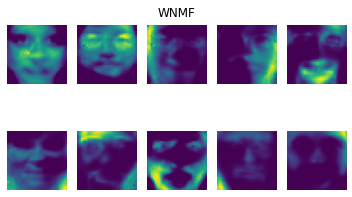

In [71]:
## WNMF
A = out['A']
A_cp = out['A_cp']
perm = np.argsort(A[0].sum(0))[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(A[1][:, perm[i]].reshape(32, 32))
    plt.axis("off")
plt.tight_layout()
plt.suptitle("WNMF")
plt.savefig(figs_path + "faces_atoms_clust_wnmf.pdf", bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1595: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


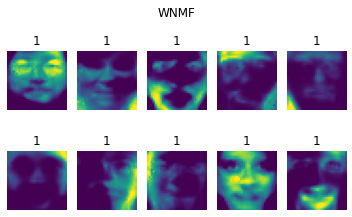

In [72]:
n_clust = 10
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust)
clust = basis_clust.fit_predict(A[1].T)

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    Y=sum([A[1][:, i].reshape(32, 32) for i in np.where(clust == perm[k])[0]])
    plt.imshow(Y, vmin = 0, vmax = np.quantile(Y, 0.995))
    plt.title(sum(clust == perm[k]))
    plt.axis('off')
plt.suptitle("WNMF")
plt.tight_layout()

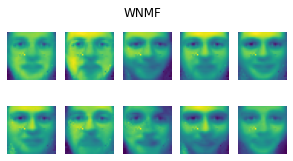

In [73]:
plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(out['X_hat'][5*i, :].reshape(32, 32))
    plt.axis("off")
plt.suptitle("WNMF")
plt.savefig(figs_path + "faces_reconstruct_wnmf.pdf", bbox_inches = 'tight')

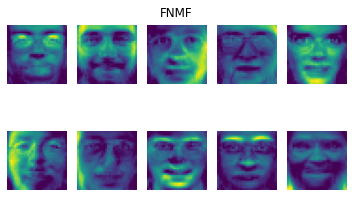

In [59]:
perm = np.argsort(A_cp[0].sum(0))[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(A_cp[1][perm[i], :].reshape(32, 32))
    plt.axis("off")
plt.tight_layout()
plt.suptitle("FNMF")
plt.savefig(figs_path + "faces_atoms_clust_fnmf.pdf", bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1595: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


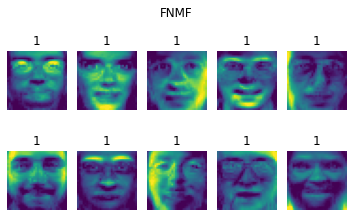

In [27]:
n_clust = 10
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust)
clust = basis_clust.fit_predict(A_cp[1])

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    Y=sum([A_cp[1][i, :].reshape(32, 32) for i in np.where(clust == perm[k])[0]])
    plt.imshow(Y, vmin = 0, vmax = np.quantile(Y, 0.995))
    plt.title(sum(clust == perm[k]))
    plt.axis('off')
plt.suptitle("FNMF")
plt.tight_layout()

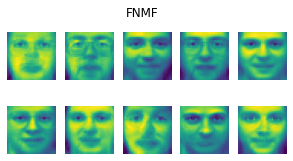

In [66]:
plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(out['X_cp'][5*i, :].reshape(32, 32))
    plt.axis("off")
plt.suptitle("FNMF")
plt.savefig(figs_path + "faces_reconstruct_fnmf.pdf", bbox_inches = 'tight')

In [28]:
np.sum([np.prod(A[i].shape) for i in range(2)])

12240

In [32]:
out = np.load("/home/zsteve/wtf/manuscript/faces/run_wtf/r_50/output_1.npz", allow_pickle = True)

In [33]:
out['nmi']

array({'ot': 0.7496271330085665, 'cp': 0.6595285940818869}, dtype=object)

In [34]:
out['classif']

array({'ot': {'err_train': 0.0, 'err_test': 0.15}, 'cp': {'err_train': 0.0, 'err_test': 0.315}, 'pca': {'err_train': 0.0, 'err_test': 0.135}},
      dtype=object)

In [35]:
## WTF
A = out['A']
A_cp = out['A_cp'][1]
target = out['target']
test_idx = out['test_idx']
train_idx = out['train_idx']

In [36]:
def stack(x, y):
    return np.stack([x, y]).reshape(-1)

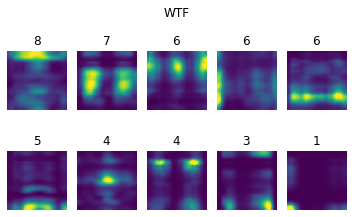

In [37]:
n_clust = 10
d = np.stack([np.kron(A[1][:, i], A[2][:, i]) for i in range(A[1].shape[1])])
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust, gamma = 0.25)
clust = basis_clust.fit_predict(d)

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    Y=sum([np.outer(A[1][:, i], A[2][:, i]) for i in np.where(clust == perm[k])[0]])
    plt.imshow(Y, vmin = 0, vmax = np.quantile(Y, 0.995))
    plt.title(sum(clust == perm[k]))
    plt.axis('off')
plt.suptitle("WTF")
plt.tight_layout()
plt.savefig(figs_path + "faces_atoms_clust_wtf.pdf", bbox_inches='tight')

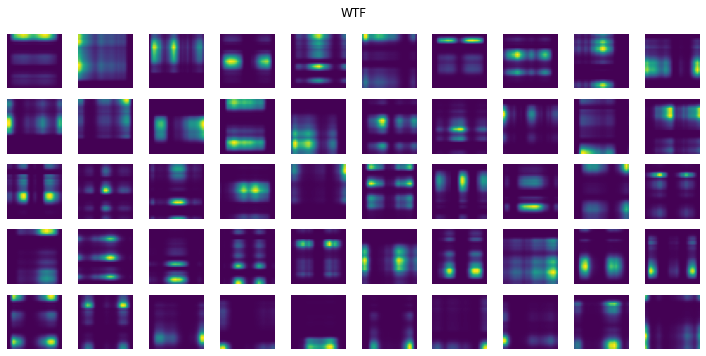

In [38]:
perm = np.argsort(A[0].sum(0))[::-1]
plt.figure(figsize = (4*PLT_CELL, 2*PLT_CELL))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(np.outer(A[1][:, perm[i]], A[2][:, perm[i]]))
    plt.axis('off')
plt.suptitle("WTF")
plt.tight_layout()
plt.savefig(figs_path + "faces_atoms_full_wtf.pdf", bbox_inches = 'tight')

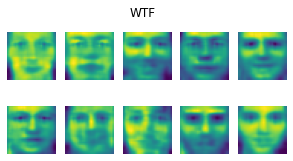

In [52]:
plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(out['X_hat'][5*i, :, :])
    plt.axis("off")
plt.suptitle("WTF")
plt.savefig(figs_path + "faces_reconstruct_wtf.pdf", bbox_inches = 'tight')

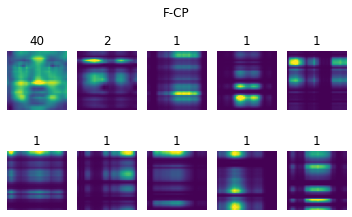

In [46]:
n_clust = 10
d = np.stack([np.kron(A_cp[1][:, i], A_cp[2][:, i]) for i in range(A[1].shape[1])])
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust, gamma = 0.25)
clust = basis_clust.fit_predict(d)

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (2*PLT_CELL, 3*PLT_CELL))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    Y=sum([np.outer(A_cp[1][:, i], A_cp[2][:, i]) for i in np.where(clust == perm[k])[0]])
    plt.imshow(Y, vmax = np.quantile(Y, 0.995))
    plt.title(sum(clust == perm[k]))
    plt.axis('off')
plt.suptitle("F-CP")
plt.tight_layout()
plt.savefig(figs_path + "faces_atoms_clust_fcp.pdf", bbox_inches = 'tight')

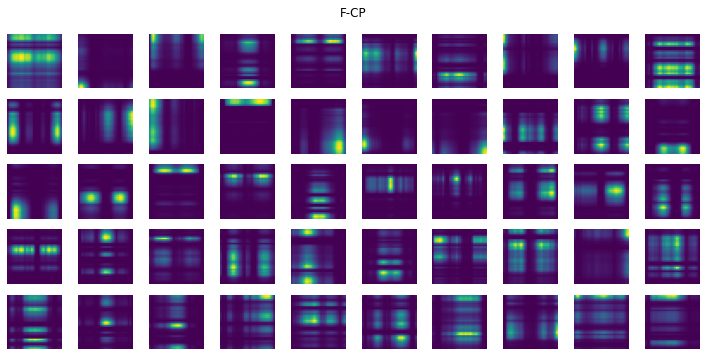

In [47]:
perm = np.argsort(A_cp[0].sum(0).numpy())[::-1]
plt.figure(figsize = (4*PLT_CELL, 2*PLT_CELL))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(np.outer(A_cp[1][:, perm[i]], A_cp[2][:, perm[i]]))
    plt.axis('off')
plt.suptitle("F-CP")
plt.tight_layout()
plt.savefig(figs_path + "faces_atoms_full_fcp.pdf", bbox_inches = 'tight')

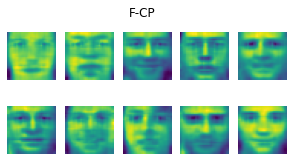

In [53]:
plt.figure(figsize = (2*PLT_CELL, 1*PLT_CELL))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(out['X_cp'][5*i, :, :])
    plt.axis("off")
plt.suptitle("F-CP")
plt.savefig(figs_path + "faces_reconstruct_fcp.pdf", bbox_inches = 'tight')

In [49]:
np.sum([np.prod(A[i].shape) for i in range(3)])

13200